### Prepare Notebook with Relevant Modules

In [ ]:
!pip install -U odp-sdk --quiet && pip list | grep odp

## 1.1 Setup ODP Client

In [ ]:
from odp.client import OdpClient # The SDK
import pandas as pd
import pydeck as pdk


### 1.2 Pydeck Plot Helper

In [ ]:
from shapely import wkt

def convert_geometry_field(data):
    for item in data:
        try:
            geom = wkt.loads(item["geometry"])
            if geom.geom_type == "Point":
                item["geometry"] = {
                    "type": "Point",
                    "coordinates": [geom.x, geom.y]
                }
            elif geom.geom_type == "MultiLineString":
                item["geometry"] = {
                    "type": "MultiLineString",
                    "coordinates": [
                        [list(coord) for coord in line.coords]
                        for line in geom.geoms
                    ]
                }
            elif geom.geom_type == "LineString":
                item["geometry"] = {
                    "type": "LineString",
                    "coordinates": [list(coord) for coord in geom.coords]
                }

        except Exception as e:
            pass

    return data


### 1.3 Geometric Plot Helper

In [ ]:
# loading a simple function to make a nice map display of points
def simple_pydeck_plot(geojson_lists, size=1, lat=0, lon=0, zoom=2):
    colors = [(3, 255, 209), (255, 216, 11), (157, 89, 244), (254, 119, 76)]  # Cyan, Yellow, Purple, Orange
    layers = []
    for i, geojson_list in enumerate(geojson_lists):
        layer = pdk.Layer("GeoJsonLayer", data=convert_geometry_field(geojson_list), lineWidthMinPixels=size, pointRadiusMinPixels=size, pickable=True, get_line_color=colors[i % len(colors)], get_fill_color=colors[i % len(colors)])
        layers.append(layer)
    r = pdk.Deck(layers=layers, initial_view_state=(pdk.ViewState(latitude=lat, longitude=lon, zoom=zoom)), map_provider="mapbox", map_style='mapbox://styles/oceandatafoundation/clwg6xklg00an01pcgmeufjxq', api_keys={'mapbox': 'pk.eyJ1Ijoib2NlYW5kYXRhZm91bmRhdGlvbiIsImEiOiJjazk5bGxpNWkwYWU1M2Vya3hkcHh4czdrIn0.yf7kIiPfDNE7KP9_9wTN6A'})
    return r

In [ ]:
client = OdpClient()

### 2.1 Fetch Metadata from Catalog
- Option 1) via API calls to the catalog
- Option 2) getting UUID or qualified name from the landing page:
https://app.hubocean.earth/catalog/dataset/1e3401d4-9630-40cd-a9cf-d875cb310449-glodap-merged-data
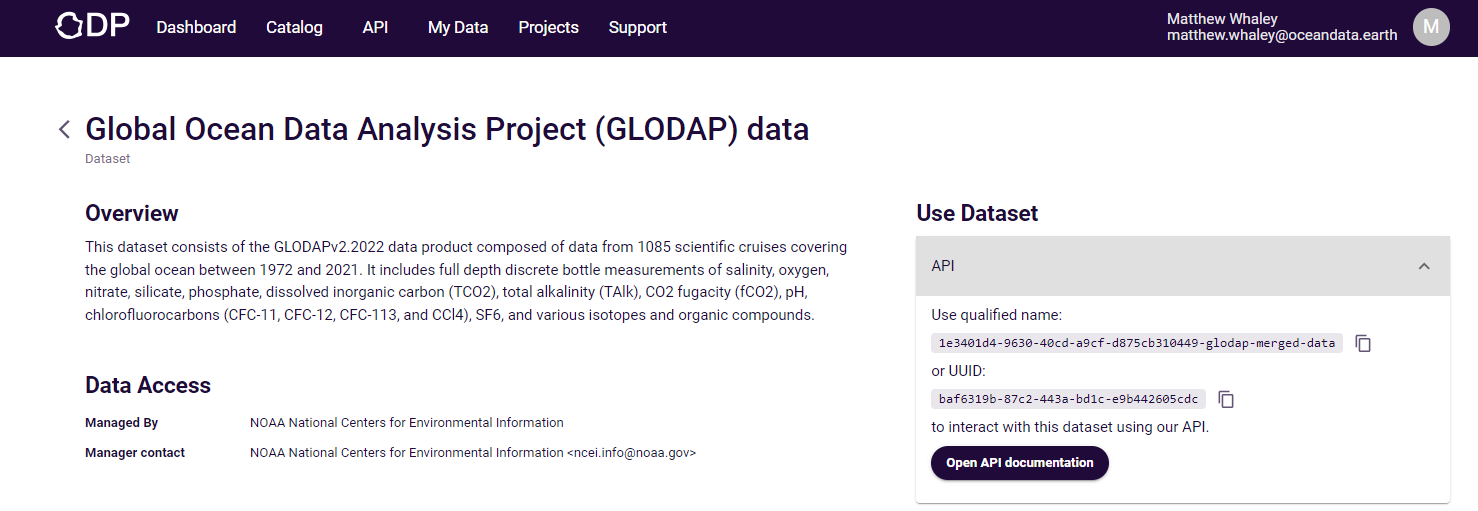

In [ ]:
## Request the dataset from the catalog using the UUID:
GLODAP = client.catalog.get("aea06582-fc49-4995-a9a8-2f31fcc65424")
print(GLODAP.metadata.display_name)
GLODAP_dataset = client.table_v2(GLODAP)


### 2.2 only fetch 5000 rows of data

In [ ]:
GLODAP_data = []
cursor = GLODAP_dataset.select()
for i, row in enumerate(cursor.rows()):
    if i >= 5_000:  
        break
    GLODAP_data.append(row)


## 3.1 Visualize Data

In [ ]:
simple_pydeck_plot([GLODAP_data], lat=30, lon=130, zoom=3)

### 3.2 Inspect Data
#### 3.2.1 Option 1: Work with List of Data Points

In [ ]:
#inspecting the fifth item of the list (numbering starts from 0)
print(GLODAP_data[4:5])

#### 3.2.2 Option 2: Convert from List to a Pandas DataFrame

In [ ]:
pd.DataFrame(GLODAP_data).head()

### 3.3.1 filter by year


In [ ]:
filtered_pages = list(GLODAP_dataset.select("G2year == 1984").pages())
GLODAP_query = [row for page in filtered_pages for row in page]

In [ ]:
pd.DataFrame(GLODAP_query).head()

### 3.3.2 plot the filtered data

In [ ]:
simple_pydeck_plot([GLODAP_query], size=1, lat=90, zoom=1)